In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Convolution2DTranspose
from tensorflow.keras.models import Sequential

## Data Loading

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

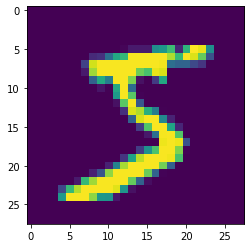

In [3]:
plt.imshow(X_train[0])

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [5]:
X_train = X_train / 255.
X_train = X_train.reshape(-1,28,28,1) * 2 - 1

In [6]:
X_train.max()

1.0

In [7]:
X_train.min()

-1.0

In [11]:
only_zeros = X_train[y_train == 0]
only_zeros.shape

(5923, 28, 28, 1)

## Model

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [17]:
generator = Sequential()

generator.add(Dense(7*7*128,input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Convolution2DTranspose(64,kernel_size=5,strides=2,
                                     padding='same',activation='relu'))
generator.add(BatchNormalization())
generator.add(Convolution2DTranspose(1,kernel_size=5,strides=2,
                                     padding='same',activation='tanh'))

In [18]:
discriminator = Sequential()

discriminator.add(Conv2D(64,kernel_size=5,strides=2,
                         padding='same',activation=LeakyReLU(0.3),
                         input_shape=[28,28,1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,
                         padding='same',activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

In [19]:
GAN = Sequential([generator,discriminator])

discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable = False

In [20]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')
GAN.layers

In [22]:
GAN.layers[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [23]:
GAN.layers[1].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 425,730
Trainable params: 212,865
Non-trainable params: 212,865
__________________________________________

In [24]:
batch_size = 32
my_data = only_zeros

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size,drop_remainder=True)

## Training Deep Convolutional GAN

In [26]:
epochs = 20

generator,discriminator = GAN.layers

for epoch in epochs:
    print(f'Currently on Epoch {epoch+1}')
    i = 0
    
    for X_batch in dataset:
        i = i +1
        if i % 20 == 0:
            print(f'Currently on batch number {i} of {len(my_data//batch_size)}')
            
        # Training Discriminator
        
        noise = tf.random.normal(shape=[batch_size,codings_size])
        
        gen_images = generator(noise)
        
        X_fake_vs_real = tf.concat([gen_images,tf.dtypes.cast(X_batch,tf.float32)],axis=0)
        
        y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
        
        discriminator.trainable = True
        
        discriminator.train_on_batch(X_fake_vs_real,y1)
        
        # Training the Generator
        
        noise = tf.random.normal(shape=[batch_size,codings_size])
        
        y2 = tf.constant([[1.]]*batch_size)
        
        discriminator.trainable = False
        
        GAN.train_on_batch(noise,y2)

print('TRAINING COMPLETE')

In [29]:
noise = tf.random.normal(shape=[10,codings_size])
noise.shape

TensorShape([10, 100])

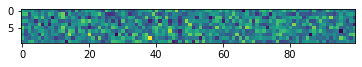

In [30]:
plt.imshow(noise)

In [ ]:
images = generator(noise)
single_image = images[0]

In [ ]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()